In [ ]:
import cv2
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

In [88]:
# padding: number of pixels to ignore at the edges of the frame
# threshold: number of pixels that need to be in the frame to be considered a hand
# max_lower_hue: maximum hue value of the hand (0 - 360)
# min_upper_hue: minimum hue value of the hand (0 - 360) 
# min_lightness: minimum lightness value of the hand (0 - 100)
def hand_is_in_frame(
        image: np.ndarray = None, 
        padding: int = 48, 
        max_lower_hue: int = 16, 
        min_upper_hue: int = 350, 
        min_lightness: int = 40, 
        max_lightness: int = 70,
        min_saturation: int = 15,
        threshold: int = 2500,
) -> bool:
    if image is None:
        return True
    
    height, width, _ = image.shape
    image = image[int(height/2-width/2):int(height/2+width/2), 0:]

    height, width, _ = image.shape
    image = image[padding:height-padding, padding:width-padding]
    h, l, s = cv2.split(cv2.cvtColor(image, cv2.COLOR_BGR2HLS))

    cv_max_lower_hue = int(max_lower_hue * 255 / 360)
    cv_min_upper_hue = int(min_upper_hue * 255 / 360) 
    h_bool = np.logical_or(h < cv_max_lower_hue, h > cv_min_upper_hue)

    cv_min_lightness = int(min_lightness * 255 / 100 )
    cv_max_lightness = int(max_lightness * 255 / 100 )
    l_bool = np.logical_and(l > cv_min_lightness, l < cv_max_lightness)

    cv_min_saturation = int(min_saturation * 255 / 100)
    s_bool = s > cv_min_saturation

    is_hand = np.logical_and(np.logical_and(h_bool, l_bool), s_bool)    
    count = np.count_nonzero(is_hand)
    segmented = np.zeros_like(image)
    segmented[is_hand] = image[is_hand]
    segmented = cv2.cvtColor(segmented, cv2.COLOR_BGR2RGB)

    return count > threshold, image, segmented, count

In [ ]:
label_path = './data_half_fps_handlabel/labelhandis1.xlsx'
label_sheet = 'labelhandis1'
label = pd.read_excel(label_path, sheet_name=label_sheet, header=None)
label = label.to_numpy()
label = label[:4,:]
label_list = []
for row in label:
    new_row = []
    for elem in row:
        if elem not in [0,1]:
            continue
        new_row.append(int(elem))
    label_list.append(new_row)
label = label_list
print(label)

In [ ]:
directory = './data_half_fps_handlabel'
images = []
for dir in os.listdir(directory):
    vid = []
    if not os.path.isdir(f'{directory}/{dir}'):
        continue
    for file in os.listdir(f'{directory}/{dir}'):
        if file.endswith('.jpg'):
            vid.append(cv2.imread(f'{directory}/{dir}/{file}'))
    images.append(vid)

False positive in video 2 frame 31 with count 3285


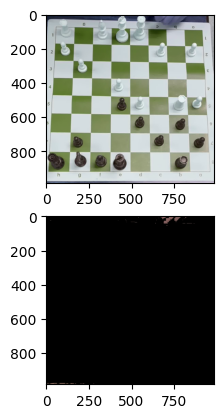

False positive in video 3 frame 75 with count 3276


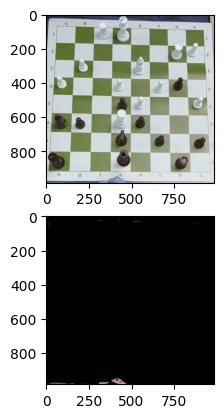

False negative in video 3 frame 262 with count 2418


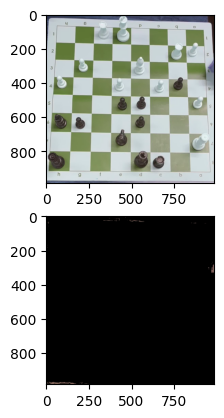

False positive in video 3 frame 318 with count 2535


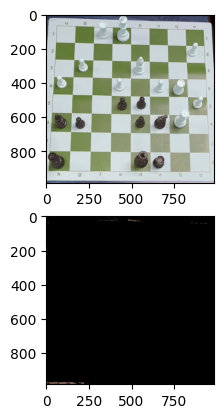

Accuracy: 0.991578947368421
Precision: 0.9464285714285714
Recall: 0.9814814814814815


In [89]:
tp, tn, fp, fn = 0, 0, 0, 0

for i, vid in enumerate(images):
    for j, img in enumerate(vid):
        predicted, org, segmented, count = hand_is_in_frame(img)
        if predicted and label[i][j] == 1:
            tp += 1
        elif predicted and label[i][j] == 0:
            fp += 1
            print(f'False positive in video {i} frame {j} with count {count}')
            f, axarr = plt.subplots(2,1) 
            axarr[0].imshow(org)
            axarr[1].imshow(segmented)
            plt.show()
        elif not predicted and label[i][j] == 1:
            fn += 1
            print(f'False negative in video {i} frame {j} with count {count}')
            f, axarr = plt.subplots(2,1) 
            axarr[0].imshow(org)
            axarr[1].imshow(segmented)
            plt.show()
        elif not predicted and label[i][j] == 0:
            tn += 1

print('Accuracy:', (tp + tn) / (tp + tn + fp + fn))
print('Precision:', tp / (tp + fp))
print('Recall:', tp / (tp + fn))

In [ ]:
##############################################################################
### DEPRECATED CODE, PARAMETER TUNING, BUT NOT UPDATED (MISSING LIGHTNESS) ###
##############################################################################


# beta = 4

# # Find optimal threshold, max_lower_hue, min_upper_hue
# best_accuracy = 0
# best_recall = 0
# best_precision = 0
# best_f_beta = 0

# # Best parameters
# best_threshold = 0
# best_max_lower_hue = 0
# best_min_upper_hue = 0
# best_min_lightness = 0
# best_max_lightness = 0

# # Parameters to search
# max_lower_hues = range(10, 21, 2)
# min_upper_hues = range(350, 361, 2)
# min_lightnesses = range(40, 51, 2)
# max_lightnesses = range(65, 76, 2)
# thresholds = range(50000, 120001, 10000)

# for max_lower_hue in max_lower_hues:
#     for min_upper_hue in min_upper_hues:
#         for min_lightness in min_lightnesses:
#             for max_lightness in max_lightnesses:
#                 for threshold in thresholds:
#                     tp, tn, fp, fn = 0, 0, 0, 0
#                     for i, vid in enumerate(images):
#                         for j, img in enumerate(vid):
#                             predicted = hand_is_in_frame(img, 0, threshold, max_lower_hue, min_upper_hue, min_lightness)
#                             if predicted and label[i][j] == 1:
#                                 tp += 1
#                             elif predicted and label[i][j] == 0:
#                                 fp += 1
#                             elif not predicted and label[i][j] == 1:
#                                 fn += 1
#                             elif not predicted and label[i][j] == 0:
#                                 tn += 1

#                     # Evaluation metrics
#                     accuracy = (tp + tn) / (tp + tn + fp + fn)
#                     if tp + fp == 0:
#                         precision = 0
#                     else:
#                         precision = tp / (tp + fp)

#                     if tp + fn == 0:
#                         recall = 0
#                     else:
#                         recall = tp / (tp + fn)

#                     if precision + recall == 0:
#                         f_beta = 0
#                     else:
#                         f_beta = (1 + beta**2) * (precision * recall) / (beta**2 * precision + recall)

#                     if f_beta > best_f_beta:
#                         best_accuracy = accuracy
#                         best_recall = recall
#                         best_precision = precision
#                         best_f_beta = f_beta

#                         best_threshold = threshold
#                         best_max_lower_hue = max_lower_hue
#                         best_min_upper_hue = min_upper_hue
#                         print(f'Parameters: threshold: {threshold}, max_lower_hue: {max_lower_hue}, min_upper_hue: {min_upper_hue}, min_lightness: {min_lightness}')
#                         print(f'F-beta: {f_beta:.4f}, Accuracy: {accuracy:.4f}, Recall: {recall:.4f}, Precision: {precision:.4f}')
#                         print("===================================================================================================================")